In [10]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# datasets
trainset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform
)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# constant for classes 
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image 
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([1, 28, 28])

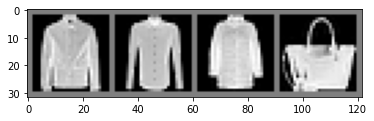

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

display(images[0].shape)
matplotlib_imshow(torchvision.utils.make_grid(images), one_channel=False)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 =nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 4 = ((28 - 4) / 2 - 4) / 2 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) # 4 = ((28 - 4) / 2 - 4) / 2 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### TensorBoard setup

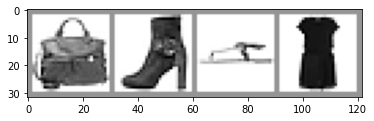

In [36]:
from torch.utils.tensorboard import SummaryWriter

writer: SummaryWriter = SummaryWriter('runs/fashion_mnist_experiment_1')

# get some random traning images
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard 
writer.add_image("four_fashion_mnist_images", img_grid)
writer.add_graph(net, images)
writer.close()

### Adding a "Projector" to TensorBoard

In [40]:
# helper function
def select_n_random(data, labels, n = 100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

display(images.shape)
# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1)) # unsqueeze to add the channel layer
writer.close()

torch.Size([100, 28, 28])

###  Tracking model training with TensorBoard

In [61]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    # squeeze remove single-dimensional entries
    preds = np.squeeze(preds_tensor.numpy())
    # TODO: Why softmax is used to calculate the probabilities here 
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    print(f"predicates are {preds}")
    print(f"probabilities are {probs}")
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig
    

running_loss = 0.0
for epoch in range(1): # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients 
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # log statistics 
        running_loss += loss.item()
        if i % 1000 == 999: # every 1000 mini-batches
            # log the running loss
            writer.add_scalar('training loss', running_loss/1000, epoch * len(trainloader) + i)
            # log a Matplotlib Figure showing the model's predictions on a random mini-batch
            # Why do we need global step? 
            fig = plot_classes_preds(net, inputs, labels)
            writer.add_figure('predictions vs. actuals',
                             fig,
                             global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')
        

predicates are [2 1 3 1]
probabilities are [0.9304382801055908, 0.796358048915863, 0.9718852639198303, 0.9997381567955017]
predicates are [3 5 7 7]
probabilities are [0.9946942925453186, 0.8672115802764893, 0.991376519203186, 0.6894599199295044]
predicates are [7 6 6 0]
probabilities are [0.9869834184646606, 0.8713938593864441, 0.8781353831291199, 0.8898876905441284]
predicates are [5 5 8 0]
probabilities are [0.9999896287918091, 0.9998924732208252, 0.9987911581993103, 0.7020822167396545]
predicates are [1 8 6 0]
probabilities are [0.9997135996818542, 0.9999579191207886, 0.5820485949516296, 0.9958983063697815]
predicates are [5 4 3 3]
probabilities are [0.9433086514472961, 0.8307095170021057, 0.9021912813186646, 0.8134459853172302]
predicates are [7 9 2 7]
probabilities are [0.9993304014205933, 0.9786509275436401, 0.9037922024726868, 0.9851797819137573]
predicates are [2 9 1 4]
probabilities are [0.9733498096466064, 0.9989425539970398, 0.9998925924301147, 0.9776301383972168]
predicates